In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn import preprocessing
from sklearn.decomposition import PCA 
import re
from mpl_toolkits.mplot3d import Axes3D

# Introduction

http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [2]:
# need to convert activity class to integer
def class_to_int(x):
    class_int = {"A" : 1, "B" : 2, "C" : 3, "D" : 4, "E" : 5}
    return class_int[x]

In [5]:
df_train = pd.read_csv("https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv", 
                       low_memory=False, parse_dates=["cvtd_timestamp"], 
                       converters={"classe" : class_to_int})
df_train.classe = df_train.classe.astype("category")
# df_test = pd.read_csv("https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv",
#                      low_memory=False, parse_dates=["cvtd_timestamp"], 
#                       converters={"classe" : class_to_int})
# need to drop the first column (just an ID)
df_train.drop('Unnamed: 0', axis=1, inplace=True)
y = df_train.classe
df_train.drop("classe", axis=1, inplace=True)

In [6]:
df_train.shape

(19622, 158)

In [7]:
regex = "^(X|user_name|raw_timestamp_part_1|raw_timestamp_part_2|cvtd_timestamp|new_window|num_window|kurtosis|skewness|min|max|stddev|total|var|avg|ampl)"

In [8]:
for col in df_train.columns:
    if re.search(regex, col):
        df_train.drop(col, axis=1, inplace=True)

In [9]:
print("Train set: {}".format(df_train.shape))

Train set: (19622, 48)


As suspected, the majority of variable observations are missing with only about 2% of all variables being complete. As stated above, there are over 100 computed metrics (like standard deviation), so we can remove these with a regular expression. **This reduces the features from 160 down to 48**

# Data

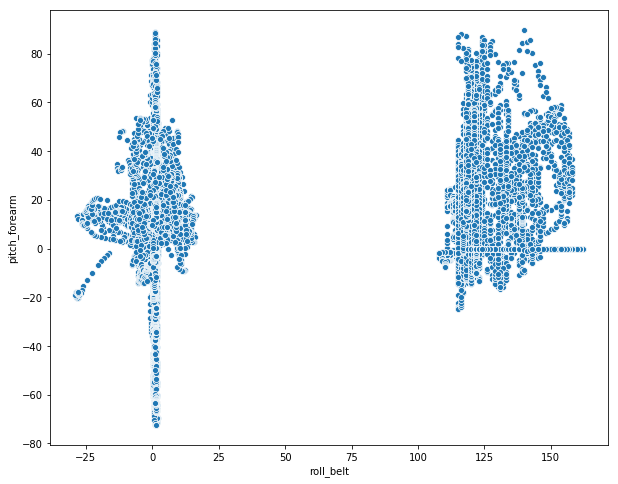

In [11]:
colors = {1 : "cyan", 2 : "orange", 3 : "green", 4 : "red", 5 : "violet"}
fig = plt.figure(figsize=(10,8))
sns.scatterplot(x="roll_belt", y="pitch_forearm", data=df_train)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19622 entries, 0 to 19621
Data columns (total 50 columns):
Unnamed: 0           19622 non-null int64
roll_belt            19622 non-null float64
pitch_belt           19622 non-null float64
yaw_belt             19622 non-null float64
gyros_belt_x         19622 non-null float64
gyros_belt_y         19622 non-null float64
gyros_belt_z         19622 non-null float64
accel_belt_x         19622 non-null int64
accel_belt_y         19622 non-null int64
accel_belt_z         19622 non-null int64
magnet_belt_x        19622 non-null int64
magnet_belt_y        19622 non-null int64
magnet_belt_z        19622 non-null int64
roll_arm             19622 non-null float64
pitch_arm            19622 non-null float64
yaw_arm              19622 non-null float64
gyros_arm_x          19622 non-null float64
gyros_arm_y          19622 non-null float64
gyros_arm_z          19622 non-null float64
accel_arm_x          19622 non-null int64
accel_arm_y          19622 

In [131]:
df_train.describe()

,Unnamed: 0,roll_belt,pitch_belt,yaw_belt,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,...,pitch_forearm,yaw_forearm,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
count,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,...,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000,19622.000000
mean,9811.500000,64.407197,0.305283,-11.205061,-5.594690,30.154877,-72.593619,55.600856,593.676995,-345.480838,...,10.705989,19.207633,0.075175,0.151245,-61.651819,163.655896,-55.291917,-312.575884,380.116445,393.613745
std,5664.527827,62.750255,22.351242,95.193926,29.644785,28.577835,100.446740,64.179286,35.680855,65.209549,...,28.145534,103.219156,3.100725,1.754483,180.593687,200.130082,138.396947,346.958482,509.373742,369.268747
min,1.000000,-28.900000,-55.800000,-180.000000,-120.000000,-69.000000,-275.000000,-52.000000,354.000000,-623.000000,...,-72.500000,-180.000000,-7.020000,-8.090000,-498.000000,-632.000000,-446.000000,-1280.000000,-896.000000,-973.000000
25%,4906.250000,1.100000,1.760000,-88.300000,-21.000000,3.000000,-162.000000,9.000000,581.000000,-375.000000,...,0.000000,-68.600000,-1.460000,-0.180000,-178.000000,57.000000,-182.000000,-616.000000,2.000000,191.000000
50%,9811.500000,113.000000,5.280000,-13.000000,-15.000000,35.000000,-152.000000,35.000000,601.000000,-320.000000,...,9.240000,0.000000,0.030000,0.080000,-57.000000,201.000000,-39.000000,-378.000000,591.000000,511.000000
75%,14716.750000,123.000000,14.900000,12.900000,-5.000000,61.000000,27.000000,59.000000,610.000000,-306.000000,...,28.400000,110.000000,1.620000,0.490000,76.000000,312.000000,26.000000,-73.000000,737.000000,653.000000
max,19622.000000,162.000000,60.300000,179.000000,85.000000,164.000000,105.000000,485.000000,673.000000,293.000000,...,89.800000,180.000000,311.000000,231.000000,477.000000,923.000000,291.000000,672.000000,1480.000000,1090.000000


In [13]:
# simply throw away variables with low variance
df_train.var().sort_values()

gyros_belt_y              0.006121
gyros_belt_x              0.042985
gyros_belt_z              0.058236
gyros_arm_z               0.305996
gyros_dumbbell_y          0.372088
gyros_forearm_x           0.420705
gyros_arm_y               0.724866
gyros_dumbbell_x          2.275733
gyros_forearm_z           3.078209
gyros_arm_x               3.974428
gyros_dumbbell_z          5.228535
gyros_forearm_y           9.614493
pitch_belt              499.578031
pitch_forearm           792.171084
accel_belt_y            816.692642
accel_belt_x            878.813290
pitch_arm               941.382186
magnet_belt_y          1273.123429
pitch_dumbbell         1368.520040
roll_belt              3937.594519
magnet_belt_x          4118.980781
magnet_belt_z          4252.285220
accel_dumbbell_x       4531.546450
roll_dumbbell          4890.445499
yaw_arm                5092.732603
roll_arm               5291.697429
accel_dumbbell_y       6520.665984
yaw_dumbbell           6809.086921
yaw_belt            

  * This technique would ignore these variables:
    1. gyros_belt_y
    2. gyros_belt_x
    3. gyros_|belt_z
    4. gyros_arm_z
    5. gyros_dumbbell_y
    6. gyros_forearm_x
    7. gyros_arm_y

In [14]:
cols_to_drop = ["gyros_belt_y","gyros_belt_x","gyros_belt_z",
                "gyros_arm_z","gyros_dumbbell_y", "gyros_forearm_x","gyros_arm_y"]
df_train.drop(cols_to_drop, axis=1, inplace=True)

In [15]:
df_train.shape

(19622, 41)

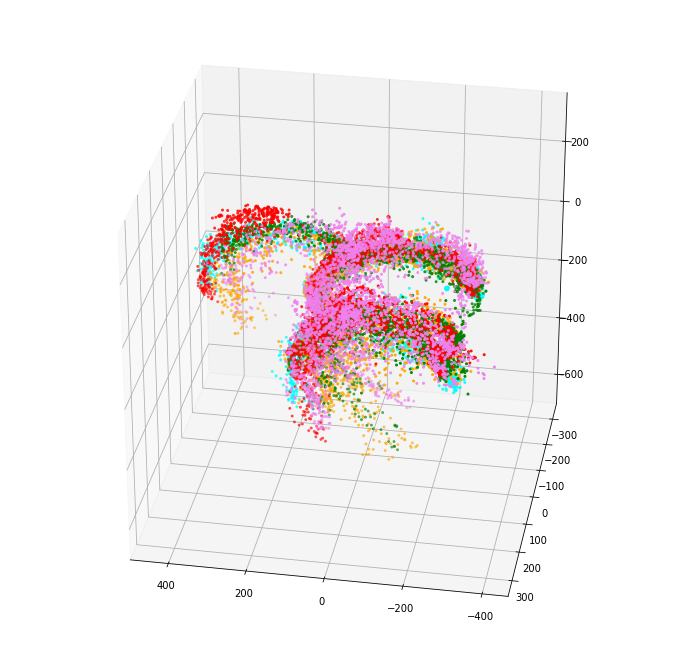

In [17]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(df[xcol], df[ycol], df[zcol], c=df["Quality Level"].apply(quality_to_color), s=4)
ax.scatter(df_train.accel_arm_x, df_train.accel_arm_y, df_train.accel_arm_z, 
           c=y.map(colors), s=4)
ax.view_init(30, 100)
plt.show()

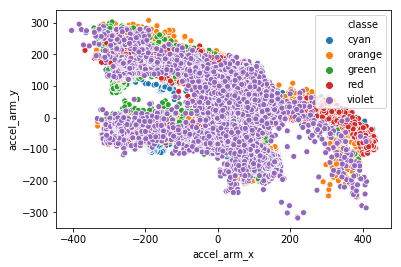

In [18]:
sns.scatterplot(df_train.accel_arm_x, df_train.accel_arm_y, hue=y.map(colors))

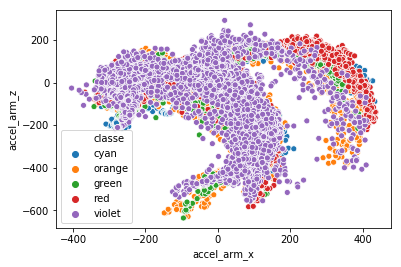

In [19]:
sns.scatterplot(df_train.accel_arm_x, df_train.accel_arm_z, hue=y.map(colors))

# PCA

We can leverage PCA as well as clustering for dimensionality reduction. First let us compute the importance of each of the predictors. The roll_belt variable is by far the most “important.” Using this information in addition to some PCA we can get a better idea of which variables we should try and cluster.

In [20]:
y.value_counts()

1    5580
2    3797
5    3607
3    3422
4    3216
Name: classe, dtype: int64

**Scale** all features in the train set (minus the output, classe)

In [21]:
scaled = pd.DataFrame(preprocessing.scale(df_train))
scaled.columns = df_train.columns

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [23]:
def conduct_pca(df, y, components, start_index, end_index):
    X = df.iloc[:,start_index:(end_index+1)]
    pca = PCA(n_components=components)
    pca.fit(X.values, y.values)
    print(pca.explained_variance_)
    X_new = pca.transform(X)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=X_new[:,0], y=X_new[:,1])
    plt.show()

In [26]:
scaled.head()

,roll_belt,pitch_belt,yaw_belt,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,...,pitch_forearm,yaw_forearm,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
0,-1.003961,0.347404,-0.873974,-0.519677,-0.915239,0.941753,-0.913104,0.149188,0.498112,-2.004754,...,-2.65079,-1.668411,-0.024245,-0.097607,1.404580,0.196598,-1.154015,0.851927,0.537701,0.223112
1,-1.003961,0.347404,-0.873974,-0.553410,-0.915239,0.941753,-0.975431,0.401430,0.528783,-2.004754,...,-2.65079,-1.668411,-0.024245,-0.097607,1.404580,0.196598,-1.161241,0.849045,0.551443,0.214988
2,-1.003802,0.347404,-0.873974,-0.485943,-0.880246,0.951709,-0.897522,0.177215,0.620797,-2.004754,...,-2.65079,-1.658723,-0.030695,-0.086207,1.426730,0.201595,-1.139563,0.849045,0.545554,0.204155
3,-1.002845,0.346509,-0.873974,-0.553410,-0.950232,0.931797,-0.959849,0.289322,0.544119,-2.004754,...,-2.65079,-1.658723,-0.030695,-0.086207,1.387968,0.211588,-1.146789,0.854810,0.545554,0.204155
4,-1.002845,0.347404,-0.873974,-0.519677,-0.985225,0.961665,-0.959849,0.177215,0.666803,-2.004754,...,-2.65079,-1.658723,-0.024245,-0.097607,1.387968,0.211588,-1.146789,0.851927,0.539664,0.214988


[1.94943285 1.0157684 ]


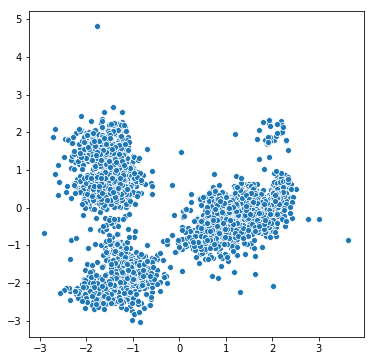

In [24]:
conduct_pca(scaled, y, 2, 3, 5)

So it looks like after we transform the train data using PCA, we can then cluster the first 2 components to reduce accel_belt_(x, y, z) into one feature:
  * Call this feature just **accel_belt_cluster**
  * **3 to 1**
  * Features: **41 down to 39**

[1.78182959 1.01406094]


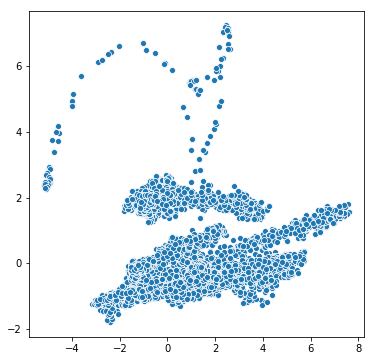

In [27]:
conduct_pca(scaled, y, 2, 6, 8)

Good for PCA, but does not appear promising to then cluster the components, so features:
  * magnet_belt_(x, y, z) becomes magnet_belt_PC1 and magnet_belt_PC2
  * **3 to 2**
  * Features: **39 down to 38** 

[1.49343838 0.92814675]


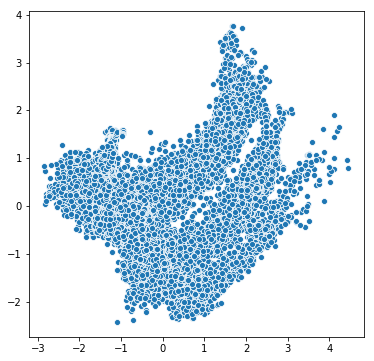

In [28]:
conduct_pca(scaled, y, 2, 13, 15)

PCA yields the above plot of the first 2 components; this appears to suggest that we can just use the first component
  * accel_arm_(x, y, z) becomes just accel_arm
  * **3 to 1**
  * Features: **38 down to 36**

[2.46370222 0.4185997 ]


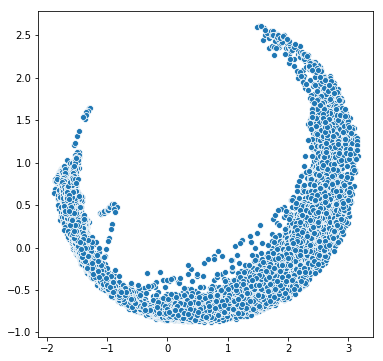

In [29]:
conduct_pca(scaled, y, 2, 16, 18)

PCA on the magnet_arm features suggests that we can simply replace these with the first component
  * magnet_arm_(x, y, z) become magnet_arm
  * **3 to 1**
  * Features: **36 down to 34**

[1.97905156 0.02105037]


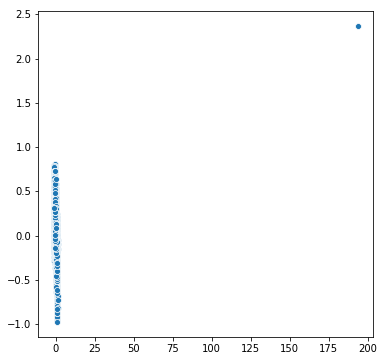

In [30]:
conduct_pca(scaled, y, 2, 22, 23)

So PCA on gyros_dumbbell_x and gyros_dumbbell_z suggest that we can replace these 2 features with the first component. However there does appear to be an outlier (200, 2.5), so we might want to keep both of these features.
  * If we ignore the one outlier, gyros_dumbbell_(x, z) becomes gyros_dumbbell
  * **2 to 1**
  * Features: **34 down to 33**

[2.17545723 0.59389857]


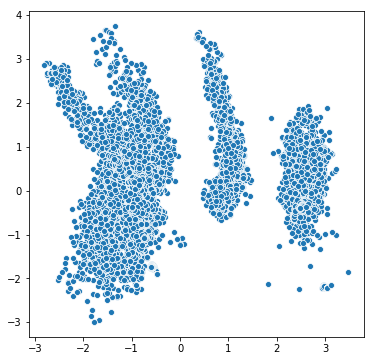

In [31]:
conduct_pca(scaled, y, 2, 24, 26)

In [35]:
df_train.columns[27]

'magnet_dumbbell_x'

Here the variance explained by the second component is less than 1, this fact in addition to the above plot suggest that we can simply replace accel_dumbbell_(x, y, z) with one feature
  * **3 to 1**
  * Features: **33 down to 31**

[1.87366802 0.90104732]


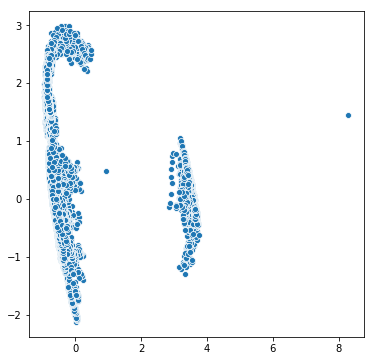

In [32]:
conduct_pca(scaled, y, 2, 27, 29)

For these features (magnet_dumbbell_(x, y, z) the majority of variance is explained by the first 2 components, but as shown above we can then cluster these into 3 clusters, so we reduce the features:
  * **3 to 1**
  * It might be a good idea to further explore the one outlier here
  * Features: **31 down to 29**

[1.84565665 0.15444528]


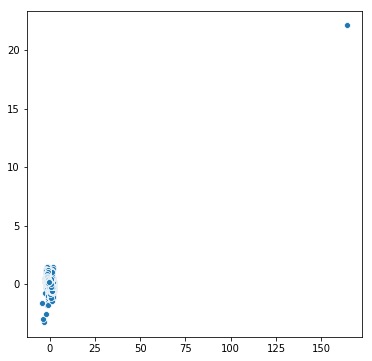

In [36]:
conduct_pca(scaled, y, 2, 33, 34)

PCA reveals that the gyros_forearm_(y, z) features can be reduced to a 1-dimensional quantity. Again we should investigate the one outlier here.
  * **2 to 1**
  * Features: **29 down to 28**

[1.34916917 1.03763197]


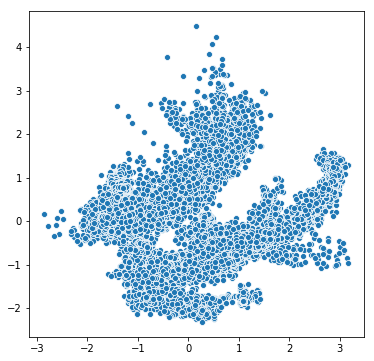

In [37]:
conduct_pca(scaled, y, 2, 35, 37)

PCA can reduce accel_forearm_(x, y, z) into it's 2 first principal components. It is not clear how to separate these 2, so we just reduce the features from:
  * **3 to 2**
  * Features: **28 down to 27**

[1.44853214 0.87782722]


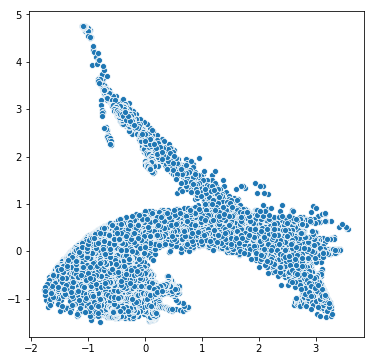

In [38]:
conduct_pca(scaled, y, 2, 38, 40)

Again, PCA yields 2 promising components that do not appear to be seperable, so we can reduce magnet_forearm_(x, y) from:
  * **3 to 2**
  * Features: **27 down to 26**

# Conclusion

The original data contains 158 features. We implemented a few simple dimensionality reduction techniques:
  1. We first discarded non-relevant info like user_name and standard deviations (via regular expressions), bringing our total number of features down from **158 to 48**
  2. 7 features had very little variance, so we discarded these as well **48 to 41**
  3. Finally, we utilized PCA to reduce the set of features:
    1. We can then replace all x, y and z tuples with it's first 2 principal components. There are 10 such 3-tuples in the original data, and after discarding those features with low variance there are 8 (meaning 2 are simply tuples). Of these 8 component tuples, we can cluster all of them to further reduce dimensionality to 1-dimensional features. 
    2. Remember that we dropped gyros_dumbbell_y and gyros_forearm_x due to the low variance these features exhibited, and we can also cluster these into one feature
    
We end up with **26 features**.